# Contents


1. Problem Difinition
2. LSTM model
3. Result discussion



## Problem Definition: Can we predict the stock price?

Another way of stating the question: is the stock price movement a random walk?




## Long Short Term Memory

You can read the article explaining how LSTM works [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)


In [ ]:
# enable and detect GPU

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Make sure the GPU device is correctly configured.")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


1. Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


2. Download the data from yahoo. We use ANZN

In [ ]:
import importlib.util
package_name = 'yfinance'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install yfinance

import yfinance as yf
df=yf.download(['AMZN', 'GOOG'], start='2012-01-01', end='2023-02-10')

df

/tmp/ipython-input-4091278394.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(['AMZN', 'GOOG'], start='2012-01-01', end='2023-02-10')
[*********************100%***********************]  2 of 2 completed


Price            Close                    High                     Low  \
Ticker            AMZN        GOOG        AMZN        GOOG        AMZN   
Date                                                                     
2012-01-03    8.951500   16.460485    8.974000   16.528267    8.777500   
2012-01-04    8.875500   16.531481    9.025000   16.580214    8.803500   
2012-01-05    8.880500   16.302164    8.912500   16.424861    8.702500   
2012-01-06    9.130500   16.079781    9.232500   16.326659    8.875000   
2012-01-09    8.928000   15.398017    9.218500   16.005073    8.850000   
...                ...         ...         ...         ...         ...   
2023-02-03  103.389999  104.504845  108.779999  107.285809  102.519997   
2023-02-06  102.180000  102.766747  103.949997  103.988382  100.650002   
2023-02-07  102.110001  107.305679  102.410004  107.931395   98.080002   
2023-02-08  100.050003   99.320328  102.669998  102.875997   98.779999   
2023-02-09   98.239998   94.811180  101.779999   99.926178   97.570000   

Price                         Open                 Volume             
Ticker            GOOG        AMZN        GOOG       AMZN       GOOG  
Date                                                                  
2012-01-03   16.137910    8.794500   16.152011  102216000  147611217  
2012-01-04   16.341993    8.960500   16.451085   84104000  114989399  
2012-01-05   16.233394    8.797000   16.379345   76182000  131808205  
2012-01-06   16.074090    8.903500   16.305631  140168000  108119746  
2012-01-09   15.367589    9.138000   15.992702  101138000  233776981  
...                ...         ...         ...        ...        ...  
2023-02-03  102.597896  105.260002  102.806468  144374800   36823400  
2023-02-06  101.515308  102.930000  101.987078   81945200   25573000  
2023-02-07  102.844206  101.169998  102.925649  119501300   33738800  
2023-02-08   97.785831  102.040001  101.992047   75878300   73546000  
2023-02-09   93.222056  101.320000   99.856654   64622500   97798600  

[2795 rows x 10 columns]

In [ ]:
df.shape

(2795, 10)

3. Visualize

In [ ]:
df['Close'].tail(10)

Ticker,AMZN,GOOG
Date,,
2023-01-27,102.239998,100.025497
2023-01-30,100.550003,97.284248
2023-01-31,103.129997,99.191200
2023-02-01,105.150002,100.740608
2023-02-02,112.910004,108.060509
2023-02-03,103.389999,104.504845
2023-02-06,102.180000,102.766747
2023-02-07,102.110001,107.305679
2023-02-08,100.050003,99.320328


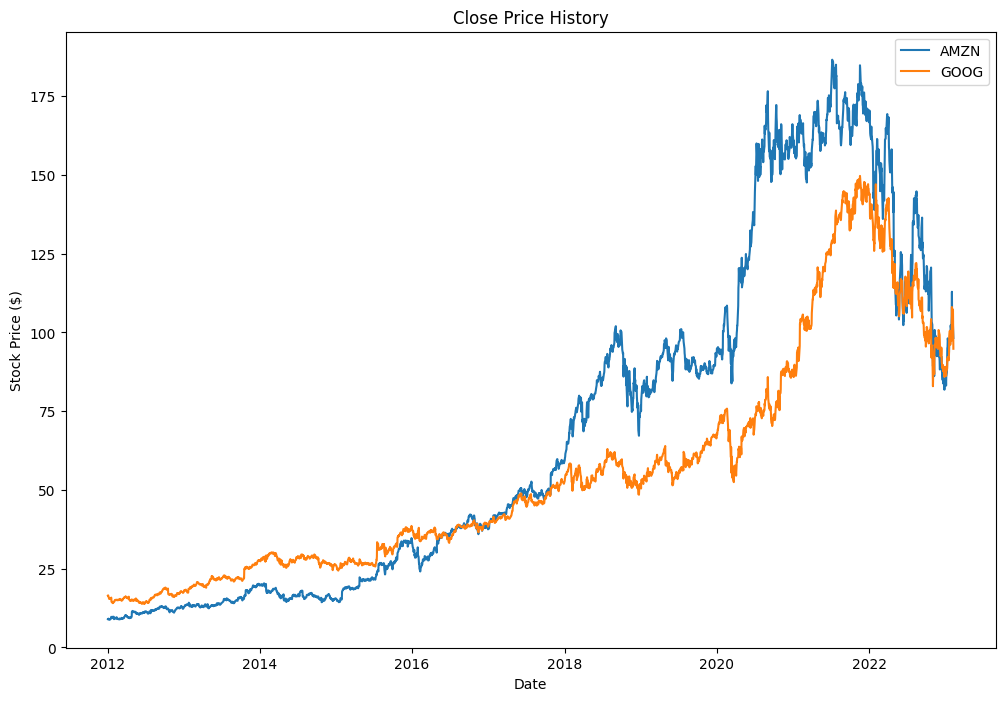

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['AMZN', 'GOOG'])

In [ ]:
data=df['Close']
data.head(20)

Ticker,AMZN,GOOG
Date,,
2012-01-03,8.9515,16.460485
2012-01-04,8.8755,16.531481
2012-01-05,8.8805,16.302164
2012-01-06,9.1305,16.079781
2012-01-09,8.9280,15.398017
2012-01-10,8.9670,15.414838
2012-01-11,8.9450,15.484599
2012-01-12,8.7965,15.575630
2012-01-13,8.9210,15.460603


4. Prepare the data

In [ ]:
#convert to numpy aarray
#We use 80 of the data for training
train_pct=0.8
dataset=data.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [ ]:
dataset.shape

(2795, 2)

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [ ]:
scaled_data.shape

(2795, 2)

In [ ]:
scaled_data[-20:]

array([[0.48642377, 0.5701355 ],
       [0.50245539, 0.57664205],
       [0.4908114 , 0.57196317],
       [0.48749255, 0.56918508],
       [0.47747985, 0.58475698],
       [0.49756152, 0.62401565],
       [0.49908029, 0.63812535],
       [0.49233016, 0.62350388],
       [0.49716777, 0.60537329],
       [0.50864302, 0.6231384 ],
       [0.52563086, 0.63447001],
       [0.51612443, 0.61429229],
       [0.53063721, 0.62832894],
       [0.54199998, 0.63973378],
       [0.58565092, 0.69361393],
       [0.53209975, 0.66744148],
       [0.52529336, 0.65464773],
       [0.52489961, 0.6880578 ],
       [0.51331187, 0.62927942],
       [0.50313038, 0.59608859]])

In [ ]:
type(scaled_data)

numpy.ndarray

### The window we use is n_period as input

In [ ]:
n_period=60
#training dataset
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data)):
    x_train.append(train_data[i-n_period:i])
    y_train.append(train_data[i,0])



In [ ]:
x_train[0:1]

[array([[0.00087189, 0.01936668],
        [0.00044438, 0.01988926],
        [0.00047251, 0.01820131],
        [0.00187879, 0.01656439],
        [0.0007397 , 0.01154608],
        [0.00095908, 0.0116699 ],
        [0.00083533, 0.0121834 ],
        [0.        , 0.01285345],
        [0.00070032, 0.01200676],
        [0.0016116 , 0.01266045],
        [0.00379977, 0.01344889],
        [0.00520886, 0.01466156],
        [0.00421884, 0.0049054 ],
        [0.00285756, 0.00481981],
        [0.0031135 , 0.00398405],
        [0.00333851, 0.00190098],
        [0.00489104, 0.00164788],
        [0.00546762, 0.00381107],
        [0.00456197, 0.00339408],
        [0.00520605, 0.00383473],
        [0.00099283, 0.00396583],
        [0.00162847, 0.00474517],
        [0.00330476, 0.00678818],
        [0.00202785, 0.00911159],
        [0.00232318, 0.00868916],
        [0.00268599, 0.00924998],
        [0.00254536, 0.00954313],
        [0.00270287, 0.00853256],
        [0.00440447, 0.00967787],
        [0.004

In [ ]:
y_train[0:1]

[np.float64(0.008066421706034416)]

In [ ]:
y_train[:2]

[np.float64(0.008066421706034416), np.float64(0.007475781350144914)]

In [ ]:
#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

(2176, 60, 2)

In [ ]:
y_train.shape

(2176,)

In [ ]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],2))
x_train.shape

(2176, 60, 2)

5. Train the model
Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
loss function is chosen as mean_squared_error'

In [ ]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

2176/2176 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0023


In [ ]:
#Test
test_data=scaled_data[train_data_len-60:,:]
x_test=[]
y_test=dataset[train_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])


x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

In [ ]:
x_test.shape

(559, 60, 2)

6. Prediction error

In [ ]:
scaled_data

array([[8.71892048e-04, 1.93666759e-02],
       [4.44381751e-04, 1.98892566e-02],
       [4.72507993e-04, 1.82013077e-02],
       ...,
       [5.24899607e-01, 6.88057801e-01],
       [5.13311875e-01, 6.29279417e-01],
       [5.03130379e-01, 5.96088591e-01]])

In [ ]:
scaler.data_max_

array([186.57049561, 149.68466187])

In [ ]:
scaler.data_min_

array([ 8.79650021, 13.82942104])

In [ ]:
predictions_scaled=model.predict(x_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
#predictions=scaler.inverse_transform(predictions)
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

In [ ]:
predictions.shape

(559, 1)

In [ ]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

np.float64(18.24457287392877)

In [ ]:
data.max()

,0
Ticker,
AMZN,186.570496
GOOG,149.684662


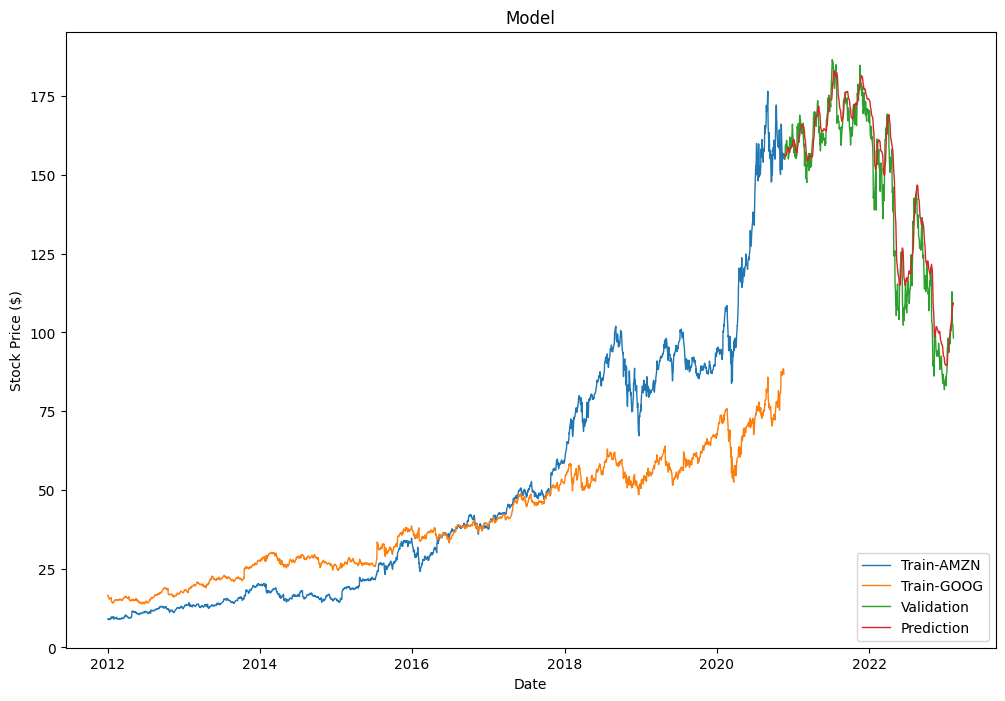

In [ ]:
#plot the result
train=data[:train_data_len]
valid=data[train_data_len:]
valid=valid.assign(Predictions=predictions)
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train, lw=1)
plt.plot(valid[['AMZN','Predictions']], lw=1)
plt.legend(['Train-AMZN','Train-GOOG', 'Validation', 'Prediction'],loc='lower right')
plt.show()

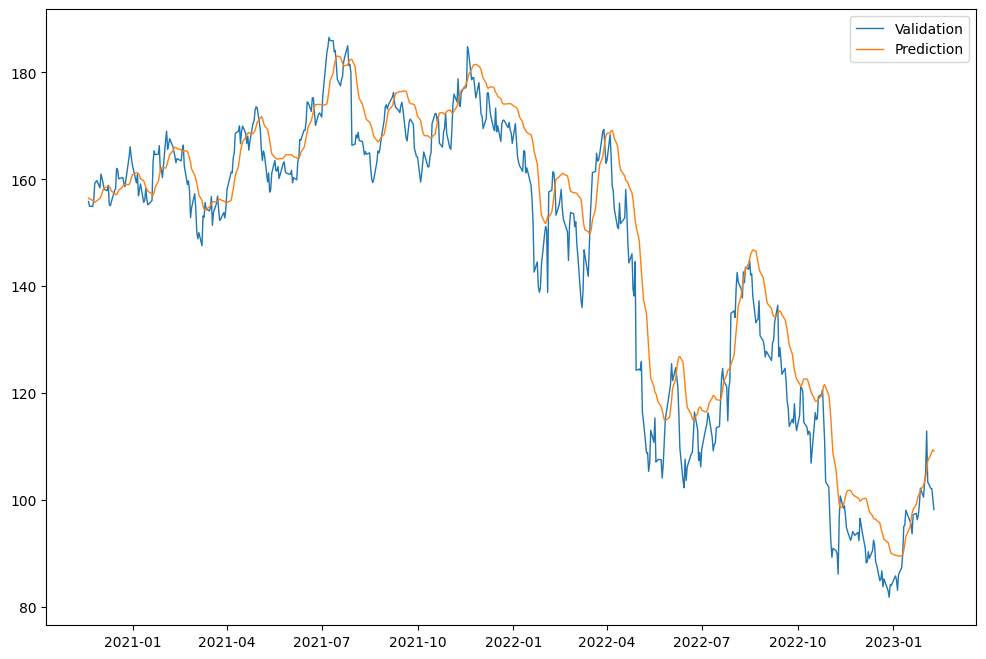

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(valid[['AMZN','Predictions']], lw=1)
plt.legend(['Validation', 'Prediction'])

# Discusion